In [52]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from torchsummary import summary

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


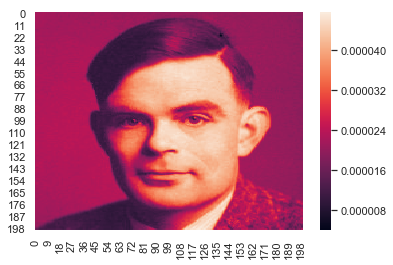

In [102]:
p_x = np.load('distribution.npy')
sns.heatmap(p_x)

In [131]:
def loss_bce(x, x_hat):
    BCE = F.binary_cross_entropy(
        x_hat.view(-1, 1), x.view(-1, 1), reduction='mean')
    return BCE


def loss_NLL(p_x, obs):
    batch_size = p_x.size(0)
    logits = torch.log(torch.gather(obs, 0, p_x.type(torch.LongTensor)).view(batch_size, -1))
#     nll_mu = torch.sum(logits) / batch_size
    nll_mu = torch.mean(-logits)
    nll_mu *= torch.log2(torch.exp(torch.tensor(1.0)))
    return nll_mu


def nn_loss2(p_x):
    loss = torch.mean(-torch.log(p_x))
    loss *= torch.log2(torch.exp(torch.tensor(1.0)))
    return loss


def train_validate(model, data, input_shape, n_classes, optim, loss_fn, train):
    batch_size = 5 * 1024
    model.train() if train else model.eval()
    
    if train:
        perm = torch.randperm(data.size(0))
        idx = perm[:batch_size]
        x = data[idx]
    else:
        x  = data
        batch_size = data.size(0)
    
    # fix this
    x1 = one_hot(x[:, 0].unsqueeze(1), n_classes)
    x2 = one_hot(x[:, 1].unsqueeze(1), n_classes)

    x = torch.cat((x1, x2), dim=1).unsqueeze(1)
    x_hat = model(x)
    
#     loss = loss_fn(x.view(batch_size, 2, n_classes), x_hat)
    loss = loss_fn(x_hat)

    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    nll = loss.clone().detach() /  (2 * np.log(2.0))
    return nll


def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_normal_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)

                
def type_tdouble(use_cuda=False):
    return torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor

def type_tlong(use_cuda=False):
    return torch.cuda.LongTensor if use_cuda else torch.LongTensor

def type_tfloat(use_cuda=False):
    return torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

def one_hot_np(labels, n_class):
    vec = np.zeros((labels.shape[0], n_class))
    for ind, label in enumerate(labels):
        vec[ind, label] = 1
    return vec


def hot2label_np(x):
    return np.argmax(x, axis=1)


def hot2label(x):
    return type_tlong() (torch.argmax(x.type(torch.LongTensor), dim=1))


def one_hot(labels, n_class):

    # Ensure labels are [N x 1]
    if len(list(labels.size())) == 1:
        labels = labels.unsqueeze(1)

    mask = type_tfloat()(labels.size(0), n_class).fill_(0)

    # scatter dimension, position indices, fill_value
    return mask.scatter_(1, labels, 1)

In [134]:
class MaskedLinear(nn.Linear):
    
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias=bias)
        self.register_buffer('mask', torch.ones([out_features, in_features]))
        self.reset_parameters()

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)
    
    def set_mask(self, mask):
        mask = torch.from_numpy(mask.astype(np.uint8).T).type(torch.FloatTensor)
        if not (self.mask.data.size() == mask.size()):
            print(self.mask.data.size())
            print(mask.data.size())
            raise Exception('size mask mismatch')
        self.mask.data.copy_(mask)
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)
     
    
class MADE1(nn.Module):
    def __init__(self, d, n_classes, hidden_sizes, shuffle_input=False):
        super(MADE1, self).__init__()
        self.input_size = d * n_classes
        self.d = d
        self.n_classes = n_classes
        hs = [self.input_size] + hidden_sizes + [input_size]
        
        self.network = []
        for in_feat, out_feat in zip(hs, hs[1:]):
            self.network.extend([MaskedLinear(in_feat, out_feat),
                           nn.ReLU(),
                            ])
        self.network.pop()
        self.network = nn.Sequential(*self.network)
        
        # Build the masks
        L = len(hidden_sizes)
        m = {}
        m[-1] = rng.permutation(self.input_size) if shuffle_input else np.arange(self.input_size)
        
        rng = np.random.RandomState(0)
        for l in range(L):
            m[l] = rng.randint(min(m[l - 1]), self.input_size - 1, size=hidden_sizes[l])

        # Build W Masks
        masks = []
        for l in range(L):
            W = m[l-1][:, None] <= m[l][None, :]
            masks.append(W)
        # V mask
        V = m[L-1][:, None] < m[-1][None, :]
        masks.append(V)

        # Set masks in network
        mask_layers = [l for l in self.network.modules() if isinstance(l, MaskedLinear)]
        for layer, mask in zip(mask_layers, masks):
            layer.set_mask(mask)
        
        
    def forward(self, x):
        x = self.network(x)
        x = x.view(-1, self.d, self.n_classes)
        x = F.softmax(x, dim=2)
        return x    

In [144]:
# Sample 100.000 points from this distribution, split 80/20 test train
samples = np.random.choice(np.prod(p_x.shape), p=p_x.ravel(), size=100000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_x, samples_y], axis=1)
train, valid = train_test_split(samples, test_size=0.2)

d = 2
n_classes = 200
input_size = d * n_classes
hidden_sizes = [400, 200, 400]
hidden_sizes = [200]

model = MADE1(d, n_classes, hidden_sizes, False)

optim = Adam(model.parameters(), lr=0.001)
loss_fn = loss_NLL
loss_fn = nn_loss2
n_epochs = 200

train = torch.from_numpy(train).type(torch.LongTensor)
valid = torch.from_numpy(valid).type(torch.LongTensor)
train_loss = []
val_loss = []
for epoch in range(0, n_epochs):    
    t_loss = train_validate(model, train, input_size, n_classes, optim, loss_fn, train=True)
    train_loss.append(t_loss)
    
    if epoch % 100 == 0:
        v_loss = train_validate(model, valid, input_size, n_classes, optim, loss_fn, train=False)
        val_loss.append(v_loss)


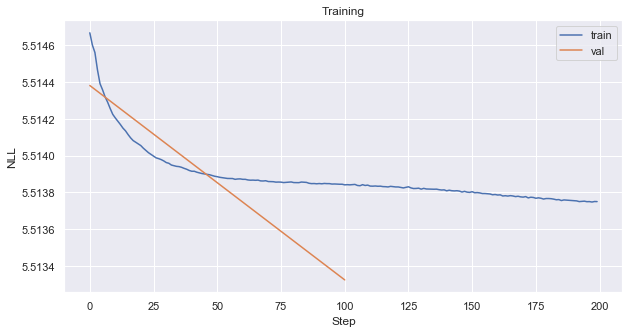

In [145]:
# sns.set()
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 100, 100), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('NLL')
plt.legend()
plt.grid(True)

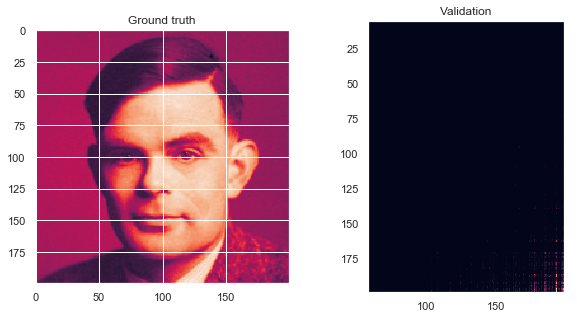

In [146]:
# FIX THIS, perhas try the HW1_1 approach with 1D output
# FIX made for different output dimensions!
import cv2

grid = np.asarray([(x, y) for x in range(200) for y in range(200)])
grid = torch.from_numpy(grid).type(torch.LongTensor)

x1 = one_hot(grid[:, 0].unsqueeze(1), 200)
x2 = one_hot(grid[:, 1].unsqueeze(1), 200)

x = torch.cat((x1, x2), dim=1).unsqueeze(1)
   
xhat = model(x)

xhat = xhat.detach().numpy()

x1_hat = xhat[:, 0, :]
x2_hat = xhat[:, 1, :]

x1_labels = hot2label_np(x1_hat)
x2_labels = hot2label_np(x2_hat)

plt.rcParams['figure.figsize'] = 10, 5
fig, axis = plt.subplots(nrows=1, ncols=2)

axis[0].imshow(p_x)
axis[0].set_title('Ground truth')

axis[1].hist2d(x1_labels, x2_labels, bins=[200, 200])
axis[1].set_title('Validation')
axis[1].set_aspect('equal', 'box')
axis[1].invert_yaxis()